In [1]:
import emcee
import matplotlib
import numpy as np
import corner
import scipy.optimize as op

%matplotlib inline  

# some important variables
g = 6.6743e-8
msun = 1.989e33
au = 1.496e13
pi = 3.14159

In [2]:
nbin = 60 ## number of binaries in sample
nvar = 5
fehon = 0 ## turn on Fe/H fit

## read in delK, parallax
delk = np.zeros(nbin)
edelk = np.zeros(nbin)
plxval = np.zeros(nbin)
plxprior = np.zeros(nbin)
name = strs = ['']*nbin
k = np.zeros(nbin)
ek = np.zeros(nbin)
feh = np.zeros(nbin)
f = open('data2.txt','r')
header1 = f.readline()
i=0
for line in f:
    line = line.strip()
    columns = line.split()
    name[i] = columns[0]
    delk[i] = float(columns[1])
    edelk[i] = float(columns[2])
    plxval[i] = float(columns[3])
    plxprior[i] = float(columns[4])
    k[i] = float(columns[5])
    ek[i] = float(columns[6])
    feh[i] = float(columns[8])
    i+=1
f.close()

## now for the sma**3/per**2
f = open('fits.txt','r')
header1 = f.readline()
i=0
smaper = np.zeros(nbin)
esmaper = np.zeros(nbin)
for line in f:
    line = line.strip()
    columns = line.split()
    smaper[i] = float(columns[0])
    esmaper[i] = float(columns[1])
    i+=1
f.close()

fluxratio = 10.0**(delk/2.5)
del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
kp = del_eps+k
ks = kp + delk

# compute MC errors on Kp, Ks
mcsize = 50000
ekp = kp*0.
eks = ks*0.
for i in range(0,len(ks)):
    ktmp = k[i]+ek[i]*np.random.standard_normal(mcsize)
    deltmp = delk[i]+edelk[i]*np.random.standard_normal(mcsize)
    fluxratio = 10.0**(deltmp/2.5)
    del_eps = 2.5*np.log10(1.0+1.0/fluxratio)
    kpt = del_eps+ktmp
    kst = kp[i] + ktmp
    ekp[i] = np.std(kpt)
    eks[i] = np.std(kst)


result_ben = np.array([0.2311,-0.1352, 0.0400, 0.0038, -0.0032]) # benedict fit value
result1 = np.array([0.23323026,-0.10887911, 0.019990399, 0.00027286744, -0.00046073982])# Mann fit value
result2 = plxval
result_delf = [0.001*1.8,0.001*6.12,0.001*13.205,-6.2315*0.001,0.001*0.37529]

result3= np.array([-0.663541,-0.212175 , 0.00594868 ,  0.00641549, -0.000416446]) ## one I measured in IDL
fehcoeff = np.array([0.01])
result_ben_test = np.concatenate([result_ben,np.array([0.00]),result2])
result_nofeh = np.concatenate([result3,result2])
result3_base = result3
if nvar-fehon == 4:
    result3 = np.array([-0.64929964,-0.19901594,0.0011934525,0.0032461656])
if nvar-fehon == 5:
    result3= np.array([-0.64372527,-0.20007154,-0.0037546659,0.0033291741,0.00027382806])
if fehon == 1:
    result = np.concatenate([result3,fehcoeff,result2])
if fehon != 1:
    result = np.concatenate([result3,result2])
print result[0:nvar]
print result[nvar:result.size]

[ -6.43725270e-01  -2.00071540e-01  -3.75466590e-03   3.32917410e-03
   2.73828060e-04]
[ 125.     50.1    74.6    38.2   249.9    58.3    61.8   109.59  125.3
   47.4   122.3   120.33   85.23  126.9    85.5   227.9    76.4    83.52
   58.8    72.6    52.11  107.9    63.5   167.3   373.7    47.65  171.22
   51.2    40.9    98.48  112.6    95.6    57.92  241.     99.2   128.49
  221.32   65.2   166.6   113.4    98.4    68.     39.8    84.9   117.1
   86.8    39.02   30.53   36.6    76.44   25.76   64.82   81.24   32.2
   29.52   32.5    62.05   46.36]


In [3]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
empmass = factor*smaper/plxval**3
e_empmass = empmass*np.sqrt((esmaper/smaper)**2 +9.0*(plxprior/plxval)**2)

In [4]:
## this is mostly for checking things are reasonable
mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)
a, b, c, d, e = result3_base
mka_err = 0.018## for now
mkb_err = 0.018## for now
mass1 = 10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4)
mass2 = 10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4)
mass1_err = (np.log(10)*(b+2*c*(mka-7.5)+3*d*(mka-7.5)**2+4*e*(mka-7.5)**3))*mass1*mka_err
mass2_err = (np.log(10)*(b+2*c*(mkb-7.5)+3*d*(mkb-7.5)**2+4*e*(mkb-7.5)**3))*mass2*mkb_err

model_err = np.sqrt(mass1_err**2+mass2_err**2)
model_err2 = np.sqrt(mass1_err**2+mass2_err**2)#+(scat*mass1)**2+(scat*mass2)**2 )
model = mass1+mass2

for i in range(0,len(empmass)):
    print "{:10s}".format(name[i]), \
    "{0:.3f}".format(empmass[i]),"{0:.3f}".format(e_empmass[i]), \
    "{0:.4f}".format(model[i]),"{0:.4f}".format(model_err[i]),"{0:.3f}".format(100*model_err[i]/model[i]), \
    "{0:.4f}".format(mka[i]),"{0:.4f}".format(mkb[i]), \
    "{0:.3f}".format(ekp[i]),"{0:.3f}".format(eks[i]), \
    "{0:.3f}".format(mass1[i]),"{0:.3f}".format(mass2[i]), \
    "{0:.1f}".format(np.abs(empmass[i]-model[i])/np.sqrt(e_empmass[i]**2+model_err[i]**2)), \
    "{0:.2f}".format(feh[i])
    
print np.sum((empmass-model)**2/(e_empmass**2+model_err**2))/(empmass.size-5.)

GJ623      0.494 0.004 0.4633 0.0031 0.659 6.4968 9.0678 0.023 0.023 0.354 0.110 5.7 -0.44
GJ4024     0.917 0.139 0.8902 0.0044 0.494 5.5041 6.4691 0.019 0.018 0.532 0.358 0.2 -0.09
PMJ02133+3648 0.245 0.035 0.2538 0.0014 0.548 8.1313 9.6003 0.018 0.018 0.161 0.093 0.3 -0.07
HIP11542   1.457 0.183 1.2845 0.0024 0.187 4.6013 4.8643 0.019 0.018 0.654 0.630 0.9 0.21
HD239960   0.460 0.011 0.4207 0.0027 0.631 7.1190 8.1570 0.029 0.029 0.262 0.159 3.6 -0.11
HD15285    1.389 0.079 1.2942 0.0022 0.168 4.6580 4.7310 0.020 0.018 0.650 0.644 1.2 0.41
Gl844      0.871 0.095 0.9228 0.0047 0.511 5.8306 5.9476 0.022 0.021 0.472 0.451 0.5 0.21
HIP9724    0.514 0.027 0.5609 0.0034 0.604 5.9100 9.2460 0.020 0.020 0.458 0.103 1.7 -0.14
Gl831      0.418 0.003 0.3981 0.0025 0.632 7.1793 8.3793 0.020 0.020 0.254 0.144 4.9 0.20
Gl804      0.996 0.135 0.9460 0.0043 0.450 5.2621 6.3851 0.017 0.016 0.574 0.372 0.4 -0.09
Gl747      0.429 0.026 0.4121 0.0025 0.618 7.5507 7.6637 0.021 0.020 0.212 0.200 0.6 -0.20


In [5]:
def lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar, fehon):
    zp = 7.5e0
    au = 1.496e13
    msun = 1.989e33
    g = 6.6743e-8 
    
    ## this is where we check to see if the relation always does brighter=higher mass (if not return -np.inf)
    mkt = np.linspace(4.1,11.3,50) - zp
    tmp = mkt*0
    for ii in range(nvar-fehon):
        tmp += theta[ii]*mkt**ii
    l = 10.0**tmp
    check = all(l[i] >= l[i+1] for i in xrange(len(l)-1))
    if not check:
        return -np.inf
    
    #a, b, c, d, e, f = theta[0:nvar]
    mplx = theta[nvar:theta.size]
    if np.min(mplx) <= 0:
        return -np.inf
    factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
    empmass = factor*smaper/mplx**3
    e_empmass = empmass*(esmaper/smaper)**2
    mka = kp - 5.0*(np.log10(1000.0/mplx)-1.) - zp
    mkb = ks - 5.0*(np.log10(1000.0/mplx)-1.) - zp
    factor1 = mka*0
    factor2 = mkb*0
    for ii in range(nvar-fehon):
        factor1 += theta[ii]*mka**ii
        factor2 += theta[ii]*mkb**ii
    mass1 = 10.0**(factor1)
    mass2 = 10.0**(factor2)
    if fehon == 1:
        mass1*=(1+theta[nvar-1])
        mass2*=(1+theta[nvar-1])
    #mass1 = (10.0**(a + b*mka + c*mka**2. + d*mka**3. + e*mka**4.))*(1+f*feh)
    #mass2 = (10.0**(a + b*mkb + c*mkb**2. + d*mkb**3. + e*mkb**4.))*(1+f*feh)
    if np.min(mass1) <= 0 or np.min(mass2) <= 0:
        return -np.inf
    
    mka_err = ekp
    mkb_err = eks
    factor1 = mka_err*0
    factor2 = mkb_err*0
    for ii in range(nvar-fehon):
        factor1 += ii*theta[ii]*mka**(ii-1)
        factor2 += ii*theta[ii]*mkb**(ii-1)
    mass1_err = np.abs((np.log(10.)*(factor1))*mass1*mka_err)
    mass2_err = np.abs((np.log(10.)*(factor2))*mass2*mkb_err)
    
    model_err = np.sqrt(mass1_err**2+mass2_err**2)
    model = mass1+mass2
    inv_sigma2 = 1.0/np.sqrt(e_empmass**2+model_err**2)
    return -0.5*(np.sum((empmass-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [6]:
def lnprior(theta, plxval, plxprior, nvar):
    mplx = theta[nvar:theta.size]
    lp = 0
    if np.min(mplx) <= 0:
        return -np.inf
    lp += np.sum(((mplx-plxval)**2)/(plxprior)**2)
    lp*=(-0.5)
    if not np.isfinite(lp):
        return 0.0
    return lp

In [7]:
def lnprob(theta, plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks, feh, nvar, fehon):
    lp = lnprior(theta, plxval, plxprior, nvar)
    if not np.isfinite(lp):
        return -np.inf
    like = lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar, fehon)
    if not np.isfinite(like):
        return -np.inf
    val = lp + like
    return val

In [8]:
## some tests:
theta = result
print 'make sure this is not -inf:'
print lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar, fehon)
#theta = result_nofeh
#print lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar-1, 0)
#theta = result_ben_test
#print lnlike(theta, smaper, esmaper, kp, ks, ekp, eks, feh, nvar, fehon)

make sure this is not -inf:
141.85448873


In [9]:
import time
from time import gmtime, strftime
start_time = time.time()
print time.strftime("%a, %d %b %Y %H:%M:%S", gmtime())
ndim, nwalkers = result.size, 700
pos = [result + 1e-2*result*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(plxval, plxprior, smaper, esmaper, kp, ks, ekp, eks, feh, nvar, fehon),
                               threads=6)
## burn-in and/or testing
smallstep = 10000
bigstep = 500000
pos, prob, state = sampler.run_mcmc(pos, smallstep)
print 'Finished burn/test phase runtime (minutes):'
print (time.time() - start_time)/60
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print 'Expected time (hours):'
print ((time.time() - start_time)/60)*(bigstep/smallstep)/60
print time.strftime("%a, %d %b %Y %H:%M:%S", gmtime())

Mon, 23 Apr 2018 10:36:09
Finished burn/test phase runtime (minutes):
27.1592853864
Mean acceptance fraction: 0.160
Expected time (hours):
22.6327435573
Mon, 23 Apr 2018 11:03:18


In [10]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat
best = (like == max(like))
a = arr[best,0:nvar]#np.median(arr[:,0])
print a[0,:]
print np.mean(arr[:,nvar-1]), np.std(arr[:,nvar-1])

[ -6.49389994e-01  -2.08722819e-01   1.44353391e-03   5.68397558e-03
  -2.09976838e-04]
4.3795442017e-05 0.000307287677514


In [11]:
sampler.reset()
start_time = time.time()
nsteps = bigstep
thin = 100
kwargs = {'thin': thin }
print 'Starting run!'
for i, result in enumerate(sampler.sample(pos, iterations=nsteps, **kwargs)):
    if (i+1) % 50000 == 0:
        print("{0:5.1%}".format(float(i) / nsteps)),
        ("{0:5.2%}".format((time.time() - start_time)/60))
print ' '
print 'Done, runtime (hours):'
print (time.time() - start_time)/3600
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Starting run!
10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0%  
Done, runtime (hours):
24.6098565042
Mean acceptance fraction: 0.154


In [12]:
print sampler.chain.shape
print sampler.lnprobability.shape
short = sampler.chain[:,:,0:nvar]
print short.shape

adder = ''
if fehon == 1: adder = '_feh'
## save out the relevant chains
import pyfits
pyfits.writeto('Mk-Mass_log_emcee'+str(nvar-1)+adder+'_short.fits', short, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee'+str(nvar-1)+adder+'.fits', sampler.chain, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee'+str(nvar-1)+adder+'_accept.fits', sampler.acceptance_fraction, clobber=True)
pyfits.writeto('Mk-Mass_log_emcee'+str(nvar-1)+adder+'_lnprob.fits', sampler.lnprobability, clobber=True)
short = sampler
#pyfits.writeto('Mk-Mass_log_emcee_acor2.fits', sampler.acor, clobber=True)

(700, 5000, 63)
(700, 5000)
(700, 5000, 5)


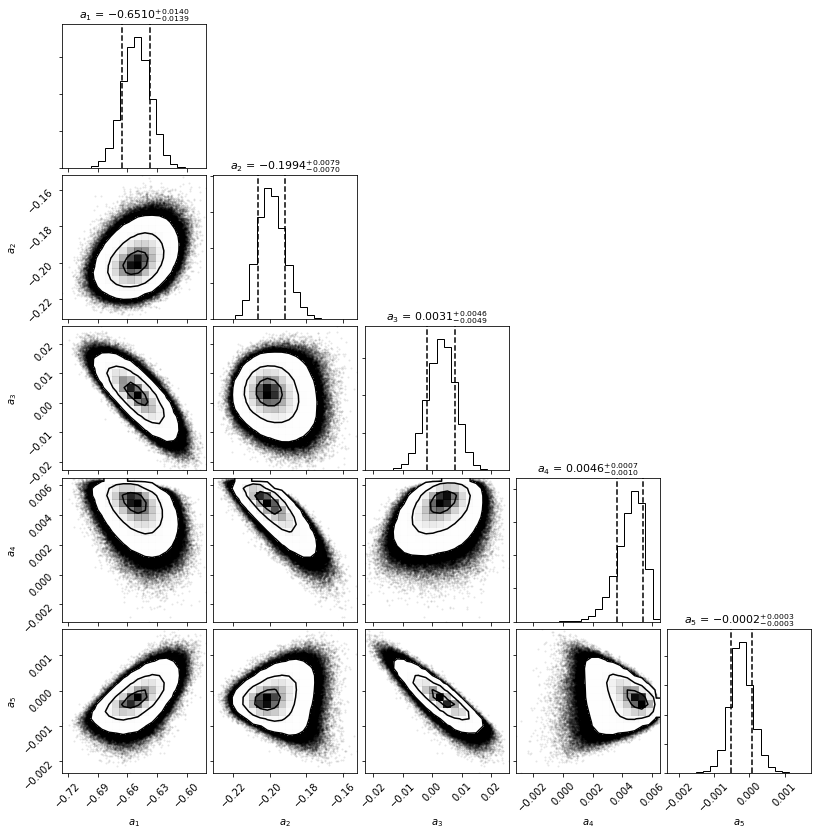

In [13]:
import corner
from matplotlib.backends.backend_pdf import PdfPages
dat = sampler.flatchain#chain
like = sampler.flatlnprobability
arr = dat
if fehon == 1:
    if nvar == 6:
        labels = [r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$a_5$',r'$f$']
        pdfname = 'output_params_5feh.pdf'
    if nvar == 5:
        labels=[r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$f$']
        pdfname = 'output_params_4feh.pdf'
if fehon == 0:
    if nvar == 5:
        labels=[r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$a_5$']
        pdfname= 'output_params_5.pdf'
    if nvar == 4:
        labels=[r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$']
        pdfname = 'output_params_4.pdf'

fig = corner.corner(arr[:,0:nvar], labels=labels, show_titles=True, title_kwargs={"fontsize": 11},title_fmt='.4f',quantiles=(0.16, 0.84), levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))])
pp = PdfPages(pdfname)
pp.savefig(fig)
pp.close()

In [14]:
dat = sampler.chain
prob = sampler.lnprobability
accept = sampler.acceptance_fraction
arr = dat.reshape((dat.shape)[0]*(dat.shape)[1],dat.shape[2])
print 'name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2'
for i in range(nvar,dat.shape[2]):
    print "{:10s}".format(name[i-nvar]), \
    i,\
    "{0:.4f}".format(np.median(arr[:,i])),"{0:.4f}".format(np.std(arr[:,i])),"{0:.4f}".format(plxprior[i-nvar]), \
    "{0:.4f}".format(plxval[i-nvar]),"{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/plxprior[i-nvar]), \
    "{0:.4f}".format((plxval[i-nvar]-np.median(arr[:,i]))/np.sqrt(plxprior[i-nvar]**2+np.std(arr[:,i])**2))
    

name plx_mcmc plx_err_mcmc plxinput plx_prior diff_sig1 diff_sig2
GJ623      5 125.0049 0.3000 0.3000 125.0000 -0.0163 -0.0115
GJ4024     6 50.8855 1.4717 2.5000 50.1000 -0.3142 -0.2708
PMJ02133+3648 7 73.9829 2.9602 3.5000 74.6000 0.1763 0.1346
HIP11542   8 39.7227 0.7421 1.6000 38.2000 -0.9517 -0.8634
HD239960   9 249.9935 1.8885 1.9000 249.9000 -0.0492 -0.0349
HD15285    10 59.0529 0.8091 1.1000 58.3000 -0.6845 -0.5514
Gl844      11 61.3488 1.6538 2.2000 61.8000 0.2051 0.1639
HIP9724    12 109.2303 1.7994 1.8700 109.5900 0.1924 0.1386
Gl831      13 125.3015 0.2996 0.3000 125.3000 -0.0048 -0.0034
Gl804      14 48.4186 1.2120 2.1000 47.4000 -0.4850 -0.4201
Gl747      15 122.3995 2.3793 2.5000 122.3000 -0.0398 -0.0288
Gl695C     16 120.3331 0.1598 0.1600 120.3300 -0.0196 -0.0139
Gl660      17 86.3141 2.1351 2.4700 85.2300 -0.4389 -0.3320
Gl54       18 126.9096 0.3999 0.4000 126.9000 -0.0240 -0.0170
Gl494      19 85.5775 1.3420 1.5000 85.5000 -0.0516 -0.0385
Gl473      20 227.5267 4.452

In [15]:
factor = (au**3.)*((4.0*np.pi**2.)/(g*msun))
mass = factor*smaper/plxval**3

mka = kp - 5.0*(np.log10(1000.0/plxval)-1.)
mkb = ks - 5.0*(np.log10(1000.0/plxval)-1.)

best = (like == max(like))
a = arr[best,0]#np.median(arr[:,0])
b = arr[best,1]#np.median(arr[:,1])
c = arr[best,2]#np.median(arr[:,2])
d = arr[best,3]#np.median(arr[:,3])
e = arr[best,4]#np.median(arr[:,4])
f = arr[best,5]
print a,b,c,d,e,f

mass1 = (10.0**(a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4))*(1+f*feh)
mass2 = (10.0**(a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4))*(1+f*feh)
sysmass = mass1+mass2
a, b, c, d, e = result1
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_mann = mass1+mass2
a, b, c, d, e = result_ben
mass1 = a + b*(mka-7.5) + c*(mka-7.5)**2 + d*(mka-7.5)**3 + e*(mka-7.5)**4
mass2 = a + b*(mkb-7.5) + c*(mkb-7.5)**2 + d*(mkb-7.5)**3 + e*(mkb-7.5)**4
sysmass_ben = mass1+mass2

[-0.66013147] [-0.20960421] [ 0.0025468] [ 0.0056145] [-0.00020096] [ 125.13768295]
